# Script to calibrate the position data of PBPS117
### Purpose: Short script to push position and diode intensity calibration values to online calculation
Contact christopher.arrell@psi.ch

In [1]:
import epics as ep
from bsread import source
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from bsread import source
from IPython.display import clear_output, display
from scipy.optimize import curve_fit
%matplotlib inline

## Setup and functions setup

In [2]:
channels = ['SAROP11-CVME-PBPS2:Lnk9Ch11-DATA-SUM','SAROP11-CVME-PBPS2:Lnk9Ch13-DATA-SUM','SAROP11-CVME-PBPS2:Lnk9Ch14-DATA-SUM','SAROP11-CVME-PBPS2:Lnk9Ch15-DATA-SUM']
channel_names = ['Down','Up','Right','Left']
Devive_prefix = "SAROP11-PBPS117:"

PBPS_x_PV_name = Devive_prefix+'MOTOR_X1.VAL'
PBPS_y_PV_name = Devive_prefix+'MOTOR_Y1.VAL'

PBPS_x_PV = ep.PV(PBPS_x_PV_name)
PBPS_y_PV = ep.PV(PBPS_y_PV_name)


def set_PBPS_x(pos):
    PBPS_x_PV.put(pos, wait=True)
def set_PBPS_y(pos):
    PBPS_y_PV.put(pos, wait=True)
    
def make_arrays(pvs, n_pulses):
    arrays = []
    for pv in pvs:
        val = pv.value

        dtype = get_dtype(val)
        shape = get_shape(val)
        shape = (n_pulses,) + shape

        arr = np.empty(shape, dtype)
        arrays.append(arr)

    return arrays

def PBPS_get_data(channels, n_pulses=100, wait_time=0.5):
    pvs = [ep.PV(ch) for ch in channels]

    n_channels = len(channels)
    counters = np.zeros(n_channels, dtype=int)

    arrays = make_arrays(pvs, n_pulses)


    def on_value_change(pv=None, ichannel=None, value=None, **kwargs):
        ivalue = counters[ichannel]
        arrays[ichannel][ivalue] = value

        counters[ichannel] += 1

        if counters[ichannel] == n_pulses:
            pv.clear_callbacks()


    for i, pv in enumerate(pvs):
        pv.add_callback(callback=on_value_change, pv=pv, ichannel=i)

    while not np.all(counters == n_pulses):
        sleep(wait_time)

    return(arrays)

def get_dtype(v):
    if is_array(v):
        return v.dtype
    else:
        return type(v)

def get_shape(v):
    if is_array(v):
        return v.shape
    else:
        return tuple()

def is_array(v):
    return isinstance(v, np.ndarray)

def PBPS_x_scan(Scan_x_range,channels, numShots):
        
    scan_mean = []
    scan_std = []
    scan_all = []
            
    for pos in Scan_x_range:
        set_PBPS_x(pos)  
        data = PBPS_get_data(channels, numShots)
        scan_mean.append([i.mean() for i in data])
        scan_std.append([i.std() for i in data])
        scan_all.append(data)
    return(np.asarray(scan_mean), np.asarray(scan_std), np.asarray(scan_all))

def PBPS_y_scan(Scan_y_range,channels, numShots):
        
    scan_mean = []
    scan_std = []
    scan_all = []
            
    for pos in Scan_y_range:
        set_PBPS_y(pos)  
        data = PBPS_get_data(channels, numShots)
        scan_mean.append([i.mean() for i in data])
        scan_std.append([i.std() for i in data])
        scan_all.append(data)
    return(np.asarray(scan_mean), np.asarray(scan_std), np.asarray(scan_all))

def PBPS_I_calibrate(channels, numShots):
        
    scan_mean = []
    scan_std = []
    scan_all = []

    data = PBPS_get_data(channels, numShots)
    scan_mean.append([i.mean() for i in data])
    scan_std.append([i.std() for i in data])
    scan_all.append(data)
    return(np.asarray(scan_mean), np.asarray(scan_std), np.asarray(scan_all))

def lin_fit(x,m,a):
    return m*x+a
def fit(xdata,ydata):
    popt, pcov = curve_fit(lin_fit, xdata, ydata)
    return(popt)

## User inputs

In [3]:
numShots = 500
Scan_x_range = np.linspace(-0.2,0.2,3)
Scan_y_range = np.linspace(-0.2,0.2,3)

## Calibrate diode response

In [4]:
scan_I_mean,scan_I_std, scan_I_all = PBPS_I_calibrate(channels, numShots)
norm_diodes = np.asarray([1 / tm / 4 for tm in scan_I_mean])

## Measure position response

In [13]:
scan_x_mean,scan_x_std, scan_x_data = PBPS_x_scan(Scan_x_range, channels, numShots)
set_PBPS_x(0)

In [14]:
scan_y_mean,scan_y_std, _ = PBPS_y_scan(Scan_y_range, channels, numShots)
set_PBPS_y(0)

## Calibrate

In [15]:
scan_x_norm = (scan_x_mean[:,3]*norm_diodes[0,3]-scan_x_mean[:,2]*norm_diodes[0,2])/(scan_x_mean[:,3]*norm_diodes[0,3]+scan_x_mean[:,2]*norm_diodes[0,2])
scan_y_norm = (scan_y_mean[:,1]*norm_diodes[0,1]-scan_y_mean[:,0]*norm_diodes[0,0])/(scan_y_mean[:,1]*norm_diodes[0,1]+scan_y_mean[:,0]*norm_diodes[0,0])


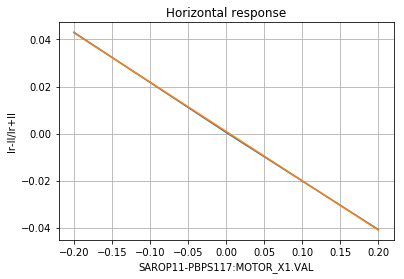

In [16]:
popt_norm_x = fit(Scan_x_range,scan_x_norm)
plt.figure()
plt.title('Horizontal response')
plt.plot(Scan_x_range, scan_x_norm)
plt.plot(Scan_x_range,lin_fit(Scan_x_range,*popt_norm_x))
plt.xlabel(PBPS_x_PV_name)
plt.ylabel("Ir-Il/Ir+Il")
plt.grid(True)

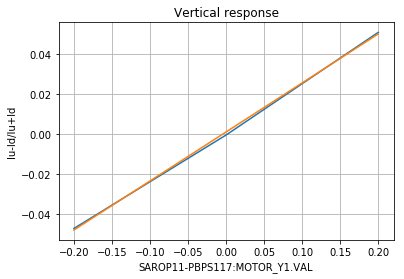

In [17]:
popt_norm_y = fit(Scan_y_range,scan_y_norm)
plt.figure()
plt.title('Vertical response')
plt.plot(Scan_y_range, scan_y_norm)
plt.plot(Scan_y_range,lin_fit(Scan_y_range,*popt_norm_y))
plt.xlabel(PBPS_y_PV_name)
plt.ylabel("Iu-Id/Iu+Id")
plt.grid(True)

## Push to calculation on IOC level

In [18]:
# Intensity
# Set channels
# Input data
ep.PV(Devive_prefix+'INTENSITY.INPA').put(bytes(channels[0], "utf8"))
ep.PV(Devive_prefix+'INTENSITY.INPB').put(bytes(channels[1], "utf8"))
ep.PV(Devive_prefix+'INTENSITY.INPC').put(bytes(channels[2], "utf8"))
ep.PV(Devive_prefix+'INTENSITY.INPD').put(bytes(channels[3], "utf8"))
# Calibration values
ep.PV(Devive_prefix+'INTENSITY.E').put(bytes(str(norm_diodes[0,0]), "utf8"))
ep.PV(Devive_prefix+'INTENSITY.F').put(bytes(str(norm_diodes[0,1]), "utf8"))
ep.PV(Devive_prefix+'INTENSITY.G').put(bytes(str(norm_diodes[0,2]), "utf8"))
ep.PV(Devive_prefix+'INTENSITY.H').put(bytes(str(norm_diodes[0,3]), "utf8"))
# Calculation
ep.PV(Devive_prefix+'INTENSITY.CALC').put(bytes("A*E+B*F+C*G+D*H", "utf8"))

1

In [19]:
# XPOS
# Set channels
ep.PV(Devive_prefix+'XPOS.INPA').put(bytes(channels[2], "utf8"))
ep.PV(Devive_prefix+'XPOS.INPB').put(bytes(channels[3], "utf8"))
# Threshold value
ep.PV(Devive_prefix+'XPOS.D').put(bytes(str(0.2), "utf8"))
# Diode calibration value
ep.PV(Devive_prefix+'XPOS.E').put(bytes(str(norm_diodes[0,2]), "utf8"))
ep.PV(Devive_prefix+'XPOS.F').put(bytes(str(norm_diodes[0,3]), "utf8"))
# Null value
ep.PV(Devive_prefix+'XPOS.G').put(bytes(str(0), "utf8"))
# Position calibration value
ep.PV(Devive_prefix+'XPOS.I').put(bytes(str((Scan_x_range[1]-Scan_x_range[0])/ np.diff(scan_x_norm).mean()), "utf8"))
# Intensity threshold value
ep.PV(Devive_prefix+'XPOS.INPJ').put(bytes(Devive_prefix+'INTENSITY', "utf8"))
# Calculation
ep.PV(Devive_prefix+'XPOS.CALC').put(bytes("J<D?G:I*(A*E-B*F)/(A*E+B*F)", "utf8"))

1

In [20]:
# YPOS
# Set channels
ep.PV(Devive_prefix+'YPOS.INPA').put(bytes(channels[0], "utf8"))
ep.PV(Devive_prefix+'YPOS.INPB').put(bytes(channels[1], "utf8"))
# Threshold value
ep.PV(Devive_prefix+'YPOS.D').put(bytes(str(0.2), "utf8"))
# Diode calibration value
ep.PV(Devive_prefix+'YPOS.E').put(bytes(str(norm_diodes[0,0]), "utf8"))
ep.PV(Devive_prefix+'YPOS.F').put(bytes(str(norm_diodes[0,1]), "utf8"))
# Null value
ep.PV(Devive_prefix+'YPOS.G').put(bytes(str(0), "utf8"))
# Position calibration value
ep.PV(Devive_prefix+'YPOS.I').put(bytes(str((Scan_y_range[1]-Scan_y_range[0])/ np.diff(scan_y_norm).mean()), "utf8"))
# Intensity threshold value
ep.PV(Devive_prefix+'YPOS.INPJ').put(bytes(Devive_prefix+'INTENSITY', "utf8"))
# Calculation
ep.PV(Devive_prefix+'YPOS.CALC').put(bytes("J<D?G:I*(A*E-B*F)/(A*E+B*F)", "utf8"))

1

## Test scans
### The purpose of the cells bellow is to scan the PBPS with the calibrated values.  The results can be seen in the data buffer ui here:
[Vertical](https://ui-data-api.psi.ch/loadhash/2021-04-28/1a8990dccc058099cd5a9b489a8eff93d0f60e09951de79d968ad418970c35df)  
[Horizontal](https://ui-data-api.psi.ch/loadhash/2021-04-28/7c6a0089aac77c84f099545739bf73d7427c457efc135df1a7f1a454710162c1)

In [21]:
for pos in Scan_y_range:
    set_PBPS_y(pos)
    sleep(10)
set_PBPS_y(0)

In [22]:
for pos in Scan_x_range:
    set_PBPS_x(pos)
    sleep(10)
set_PBPS_x(0)